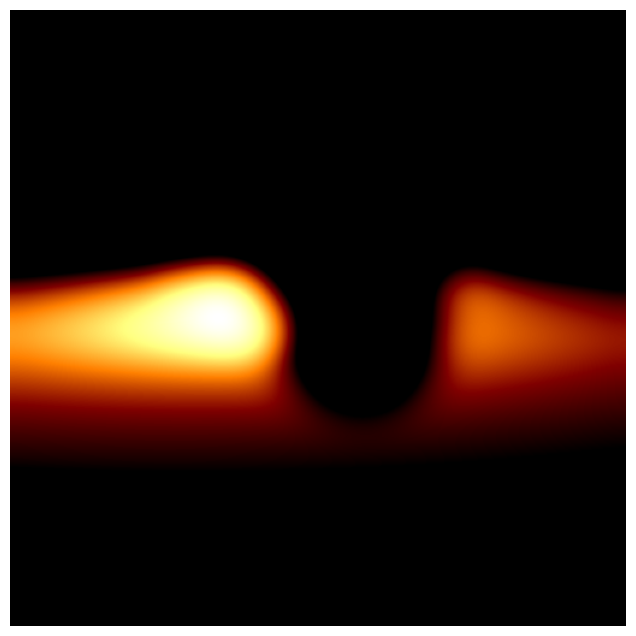

In [8]:
#muscle flexing by simulating black hole is the motive of this notebook
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import logging
import sys
import time
import scipy.ndimage as ndimage

#Logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)-8s | %(message)s",
    datefmt="%H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)]
)
log = logging.getLogger("KERR_GPU2")

#Parameters
M = 1.0
A_STAR = 0.9375
A = A_STAR * M
R_OBS = 200.0
INC_DEG = 80.0
THETA_OBS = np.deg2rad(INC_DEG)

IMG_N = 512
FOV = 10.0

P_SPEC = 2.0
R_OUTER = 28.0

DLAMBDA = 0.02
N_STEPS = 10000

R_PLUS = M + cp.sqrt(M*M - A*A)
def r_isco_prograde():
    x = A / M
    Z1 = 1 + (1 - x*x)**(1/3) * ((1 + x)**(1/3) + (1 - x)**(1/3))
    Z2 = cp.sqrt(3*x*x + Z1*Z1)
    return M * (3 + Z2 - cp.sqrt((3 - Z1)*(3 + Z1 + 2*Z2)))
R_ISCO = r_isco_prograde()

#Disk & Doppler (GPU)
def j_synchrotron(r):
    gamma = 2.0 + (P_SPEC + 1.0)/2.0
    return cp.where((r>=R_ISCO)&(r<=R_OUTER), (r/R_ISCO)**(-gamma), 0.0)

def doppler_factor(r, E, L):
    Omega = cp.sqrt(M)/(r**1.5 + A*cp.sqrt(M))
    g_tt = -(1-2*M/r)
    g_tphi = -2*M*A/r
    g_pp = r**2 + A**2 + 2*M*A*A/r
    denom = g_tt + 2*g_tphi*Omega + g_pp*Omega**2
    ut = cp.where(denom<0, 1/cp.sqrt(-denom), 1.0)
    uphi = Omega*ut
    denom2 = E*ut - L*uphi
    return cp.where(denom2>1e-12, E/denom2, 0.0)

#Kerr Potentials
def Sigma(r, th): return r**2 + A**2*cp.cos(th)**2
def Delta(r): return r**2 - 2*M*r + A**2
def R_potential(r,E,L,Q):
    term = (r**2 + A**2)*E - A*L
    return term**2 - Delta(r)*((L-A*E)**2 + Q)
def Theta_potential(th,E,L,Q):
    return Q - cp.cos(th)**2*(A**2*(1-E**2) + (L**2)/cp.sin(th)**2)

#GPU Ray Tracer
def render_gpu():
    log.info("Starting GPU-accelerated Kerr ray tracing")
    t0 = time.time()

    xs = cp.linspace(-FOV, FOV, IMG_N)
    ys = cp.linspace(-FOV, FOV, IMG_N)
    alpha, beta = cp.meshgrid(xs, ys)

    alpha = alpha.ravel()
    beta = beta.ravel()

    E = 1.0
    L = -alpha * cp.sin(THETA_OBS)
    Q = beta**2 + cp.cos(THETA_OBS)**2 * (alpha**2 - A**2)

    r  = cp.full((IMG_N*IMG_N,), R_OBS)
    th = cp.full((IMG_N*IMG_N,), THETA_OBS)

    prev_r  = r.copy()
    prev_th = th.copy()

    sign_r = cp.full((IMG_N*IMG_N,), -1.0)
    sign_th = cp.sign(-beta)
    sign_th = cp.where(sign_th == 0, 1.0, sign_th)

    intensity = cp.zeros_like(r)

    Rpot = R_potential(r, E, L, Q)
    Tpot = Theta_potential(th, E, L, Q)

    prev_Tpot = Tpot.copy()

    alive = (Rpot > -1e-5) & (Tpot > -1e-5)

    for i in range(N_STEPS):
        Rpot = R_potential(r, E, L, Q)
        Tpot = Theta_potential(th, E, L, Q)

        valid = alive & (Rpot > -1e-5) & (Tpot > -1e-5)
        if not cp.any(valid): break

        sig = Sigma(r, th)

        flip_r = valid & (Rpot <= 1e-3) & (r > R_PLUS * 1.05)
        sign_r = cp.where(flip_r, 1.0, sign_r)

        flip_th = valid & (Tpot <= 1e-3) & (Tpot <= prev_Tpot)
        sign_th = cp.where(flip_th, -sign_th, sign_th)

        pr = sign_r * cp.sqrt(cp.maximum(Rpot, 0)) / sig
        pth = sign_th * cp.sqrt(cp.maximum(Tpot, 0)) / sig

        r = r + pr * DLAMBDA
        th = th + pth * DLAMBDA

        alive &= r > R_PLUS * 1.01
        alive &= r < R_OBS * 1.5

        crossed_equator = valid & ((prev_th - cp.pi/2) * (th - cp.pi/2) <= 0.0)
        r_mid = 0.5 * (r + prev_r)
        hit = crossed_equator & (r_mid >= R_ISCO) & (r_mid <= R_OUTER)

        if cp.any(hit):
            g = doppler_factor(r_mid, E, L)
            j = j_synchrotron(r_mid)
            intensity += hit * (g**3) * j

        prev_r[:] = r
        prev_th[:] = th
        prev_Tpot[:] = Tpot

        if i % 1000 == 0:
            log.info(f"Step {i}/{N_STEPS}, alive rays: {cp.sum(alive).get()}")

    # --- POST-PROCESSING FIX ---

    # 1. FORCE SHADOW: Any ray that finished too close to the horizon is black.
    # This cleans up the central artifact.
    fell_into_bh = r <= R_PLUS * 1.02
    intensity = cp.where(fell_into_bh, 0.0, intensity)

    # 2. SAFETY NET: Convert any remaining NaNs/Infinities to 0.
    intensity = cp.nan_to_num(intensity, nan=0.0, posinf=0.0, neginf=0.0)

    img = intensity.reshape(IMG_N, IMG_N)
    dt = time.time() - t0
    log.info(f"GPU rendering completed in {dt:.2f}s")

    img_cpu = cp.asnumpy(img)

    blur_sigma = IMG_N / 40.0
    img_blurred = ndimage.gaussian_filter(img_cpu, sigma=blur_sigma)

    return img_blurred

# =============== Display ==================
def display(img, fname="kerr_gpu.png"):
    img = np.array(img, dtype=np.float64)

    # 1. THE FIX: LogNorm cannot handle 0.0.
    # We clip the absolute lowest values to a microscopic positive number.
    # This prevents the transparent "holes" while keeping the pixels dark.
    safe_min = img.max() * 1e-10
    img = np.clip(img, a_min=safe_min, a_max=None)

    if img.max() <= 0:
        raise RuntimeError("No positive intensity! All rays missed or died.")

    fig, ax = plt.subplots(figsize=(8, 8))

    # 2. SAFETY NET: Force the actual plot background to be black instead of white
    ax.set_facecolor("black")

    # Swap to afmhot and set vmin to 1e-3 to hide the background noise
    ax.imshow(
        img,
        cmap="afmhot",
        norm=LogNorm(vmin=img.max() * 1e-3, vmax=img.max()),
        origin="lower"
    )

    ax.axis("off")
    # Facecolor='black' ensures the saved file margins are also black
    plt.savefig(fname, dpi=300, bbox_inches="tight", facecolor='black')
    plt.show()

# =============== MAIN ==================
if __name__=="__main__":
    img = render_gpu()
    log.info(f"Shadow pixels: {np.sum(img==0)} / {IMG_N**2}")
    log.info(f"Max intensity: {np.nanmax(img):.4e}")
    display(img)
    log.info("Simulation finished successfully")